# Difference in Difference (DID)

## DID Estimator

Difference in differences ($DiD$) is a tool to estimate treatment effects comparing the pre- and post-treatment differences in the outcome of a treatment and a control group. In general, we are interested in estimating the effect of a treatment $D_i$ (e.g. union status, medication, etc.) on an outcome $Y_i$ (e.g. wages, health, etc.)

## Parallel Trend Assumption

- This assumption that nothing else changes at the same time, is the poorly-named "parallel trends"
- If the Treatment hadn't happened to anyone, the gap between the two would have stayed the same

## The 2 X 2 DID

The 2X2 DD design has a **treatment** group $k$ and **untrated** (Control) group $U$. there is a pre-period for the treatment group, $pre(k)$; a post-period for the treatment group, $post(k)$; a pre-treatment period fo the control group, $pre(U)$; ad a post-perdio for the control group, $post(U)$

So:

$$
\widehat{\delta}^{2\times 2}_{kU} = \bigg ( \overline{y}_k^{-post(k)} - \overline{y}_k^{-pre(k)} \bigg ) - \bigg ( \overline{y}_U^{-post(k)} - \overline{y}_U^{-pre(k)} \bigg )
$$


where $\hat\delta_{kU}$ is the estimated ATT for group $k$, and $\tilde y$ is the sample mean for that particular group in a particular time period. The first paragraph differences the treatment group, $k$, after minus before, the second paragraph differences the control group, $U$, after minus before. And once those quantities are obtained, we difference the second term from the first.


Graphically this would look something like this:


![](figs/DID.png)

### Aplication: Billboard Impact

3 billboards were placed in the city of Porto Alegre - Brazil (treated group), and it is wanted to see if this increased deposits in the bank.

And for the control group, the data from Florianopolis was seen, the idea is to use Florianopolis to estimate the counterfactual in comparison to Porto Alegre.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

b_impact = pd.read_csv("https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/billboard_impact.csv")
b_impact.head()

,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0


Deposits are our outcome variable, the one we wish to increase with the billboards. POA is a dummy indicator for the city of Porto Alegre. When it is zero, it means the samples are from Florianopolis. Jul is a dummy for the month of July, or for the post intervention period. When it is zero it refers to samples from May, the pre-intervention period.

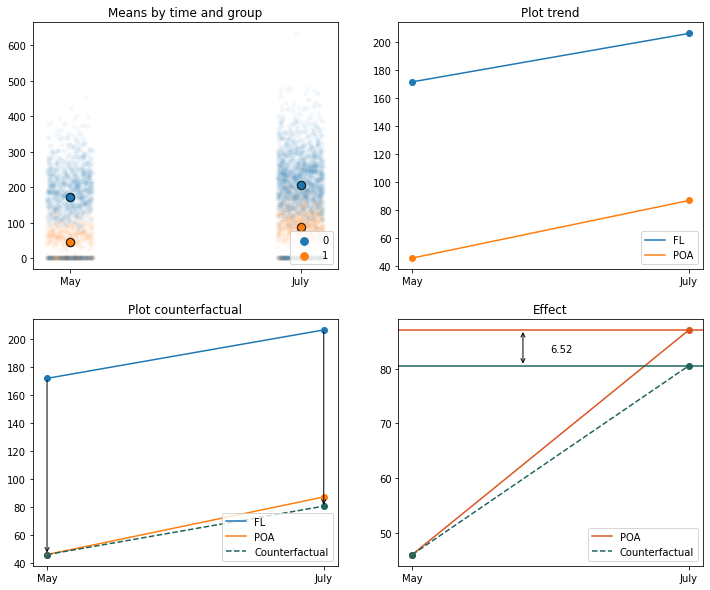

In [2]:


poa_mean = b_impact[b_impact.poa == 1].groupby(["jul"]).mean()
no_poa_mean = b_impact[b_impact.poa == 0].groupby(["jul"]).mean()


import seaborn as sns
fz = 12
# Legend labesl
t_t = "POA"
c_c = "FL"
t_c = "Counterfactual"
# Legend color 

t_c_c = "#20635E"
t_t_c = "#DC5420"


fig, ax = plt.subplots(2, 2, figsize = (fz, fz - 2))

sns.stripplot(data = b_impact, x = "jul", y = "deposits", hue = "poa", alpha = .04, ax=ax[0, 0])

ax[0, 0].scatter(poa_mean.index, no_poa_mean.deposits, s = fz*6, color = "black")
ax[0, 0].scatter(poa_mean.index, poa_mean.deposits, s = fz*6, color = "black")
ax[0, 0].scatter(poa_mean.index, no_poa_mean.deposits, s = fz*3)
ax[0, 0].scatter(poa_mean.index, poa_mean.deposits, s = fz*3)
ax[0, 0].set_title("Means by time and group")
ax[0, 0].set_xlabel("")
ax[0, 0].set_ylabel("")


ax[0, 1].scatter(poa_mean.index, no_poa_mean.deposits)
ax[0, 1].plot(poa_mean.index, no_poa_mean.deposits, label = c_c)
ax[0, 1].scatter(poa_mean.index, poa_mean.deposits)
ax[0, 1].plot(poa_mean.index, poa_mean.deposits, label = t_t)
ax[0, 1].set_title("Plot trend")


par = no_poa_mean.unstack() - poa_mean.unstack()
new_poa = no_poa_mean.unstack() - par[0]
new_poa = pd.DataFrame(new_poa[:2], columns=["deposits"]) 

ax[1, 0].scatter(poa_mean.index, no_poa_mean.deposits)
ax[1, 0].plot(poa_mean.index, no_poa_mean.deposits, label = c_c)
ax[1, 0].scatter(poa_mean.index, poa_mean.deposits)
ax[1, 0].plot(poa_mean.index, poa_mean.deposits, label = t_t)
ax[1, 0].scatter(poa_mean.index, new_poa.deposits, color = t_c_c)
ax[1, 0].plot(poa_mean.index, new_poa.deposits, linestyle = "--", label = t_c, color = t_c_c)
ax[1, 0].annotate("", xy = (0, 171.64), xytext = (0, 46.01), 
            arrowprops=dict(arrowstyle="<-",
                            connectionstyle="arc3"))
ax[1, 0].annotate("", xy = (1, 206.16), xytext = (1, 80.06), 
            arrowprops=dict(arrowstyle="<-",
                            connectionstyle="arc3"))
ax[1, 0].set_title("Plot counterfactual")

eff = (poa_mean.unstack() - new_poa.unstack())
effect = round(eff.iloc[0, 1], 2)

ax[1, 1].scatter(poa_mean.index, poa_mean.deposits, color = t_t_c)
ax[1, 1].plot(poa_mean.index, poa_mean.deposits, label = t_t, color = t_t_c)
ax[1, 1].scatter(poa_mean.index, new_poa.deposits, color = t_c_c)
ax[1, 1].plot(poa_mean.index, new_poa.deposits, linestyle = "--", label = t_c, color = t_c_c)
ax[1, 1].axhline(87.06, color = t_t_c)
ax[1, 1].axhline(80.53, color = t_c_c)
ax[1, 1].annotate("", xy = (.4, 87.06), xytext = (.4, 80.53), 
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"))
ax[1, 1].annotate(f"{effect}", xy = (.5, 83))
ax[1, 1].set_title("Effect")
# ax[1, 1].xlim(-.1, 1.1)

for i in range(2):
    for j in range(2):
        ax[i, j].legend(loc = "lower right")
        ax[i, j].set_xticks([0, 1])
        ax[i, j].set_xticklabels(["May", "July"])



Using the switching equation, and assuming a constant state fixed effect and time fixed effect, we can write out a simple regression model. This simple  is estimated with the following equation:

$$
Y = \beta_0 + \beta_1TreatedGroup + \beta_2AfterTreatment + \\ \beta_3TreatedGroup\times AfterTreatment + \varepsilon
$$

![](figs/EQ.png)

In [3]:

# Estimate effect 

import statsmodels.formula.api as smf
smf.ols('deposits ~ poa*jul', data=b_impact).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,171.6423,2.363,72.625,0.000,167.009,176.276
poa,-125.6263,4.484,-28.015,0.000,-134.418,-116.835
jul,34.5232,3.036,11.372,0.000,28.571,40.475
poa:jul,6.5246,5.729,1.139,0.255,-4.706,17.755


## Twoway Fixed Effects with Differential Timming

Difference-in-differences can be modified just a bit to allow the effect to differ in each time period. In other words, we can have dynamic treatment effects. This lets you see things like the effect taking a while to work, or fading out.


A common way of doing this is to first generate a centered time variable, which is just your original time variable minus the treatment period. So time in the last period before treatment is $t = 0$, the first period with treatment implemented is $t = 1$, the second-to-last period before treatment is $t = -1$, and so on.

Then, interact your $Treatment$ variable with a set of binary indicator variables for each of the time periods.

$$
Y = \alpha_g + \alpha_t + \\
    \beta_{-T_1}Treated + \beta_{-(T_1-1)}Treated + ... + \beta_{-1}Treated + \\
    \beta_1Treated + ... + \beta_{T_2}Treated + \varepsilon
$$

### Aplication: Cheng y Hoekstra (2013)

Cheng and Hoekstra (2013) evaluated the impact that a gun reform had on violence and to illustrate various principles and practices regarding differential timing.


#### Context

Between 2000 and 2010, twenty-one states explicitly expanded the castle-doctrine statute by extending the places outside the home where lethal force could be legally used.15 These states had removed a long-standing tradition in the common law that placed the duty to retreat from danger on the victim. After these reforms, though, victims no longer had a duty to retreat in public places if they felt threatened; they could retaliate in lethal self-defense.

From an economic perspective, these reforms lowered the cost of killing someone. One could use lethal self-defense in situations from which they had previously been barred. And as there was no civil liability, the expected cost of killing someone was now lower. Thus, insofar as people are sensitive to incentives, then depending on the elasticities of lethal self-defense with respect to cost, we expect an increase in lethal violence for the marginal victim. The reforms may have, in other words, caused homicides to rise.

One can divide lethal force into true and false positives. The true positive use of lethal force would be those situations in which, had the person not used lethal force, he or she would have been murdered. Thus, the true positive case of lethal force is simply a transfer of one life (the offender) for another (the defender). This is tragic, but official statistics would not record an net increase in homicides relative to the counterfactual—only which person had been killed. But a false positive causes a net increase in homicides relative to the counterfactual. Some arguments can escalate unnecessarily, and yet under common law, the duty to retreat would have defused the situation before it spilled over into lethal force. Now, though, under these castle-doctrine reforms, that safety valve is removed, and thus a killing occurs that would not have in counterfactual, leading to a net increase in homicides.

In [4]:
castle = pd.read_stata("https://raw.github.com/scunning1975/mixtape/master/castle.dta")

castle['time_til'] = castle['year'] - castle['treatment_date'] #cutoff

castle['lead1'] = castle['time_til'] == -1
castle['lead2'] = castle['time_til'] == -2
castle['lead3'] = castle['time_til'] == -3
castle['lead4'] = castle['time_til'] == -4
castle['lead5'] = castle['time_til'] == -5
castle['lead6'] = castle['time_til'] == -6
castle['lead7'] = castle['time_til'] == -7
castle['lead8'] = castle['time_til'] == -8
castle['lead9'] = castle['time_til'] == -9
castle['lag0'] = castle['time_til'] == 0 
castle['lag1'] = castle['time_til'] == 1 
castle['lag2'] = castle['time_til'] == 2 
castle['lag3'] = castle['time_til'] == 3 
castle['lag4'] = castle['time_til'] == 4 
castle['lag5'] = castle['time_til'] == 5 

formula = "l_homicide ~ r20001 + r20002 + r20003 + r20011 + r20012 + r20013 + r20021 + r20022 + r20023 + r20031 + r20032 + r20033 + r20041 + r20042 + r20043 + r20051 + r20052 + r20053 + r20061 + r20062 + r20063 + r20071 + r20072 + r20073 + r20081 + r20082 + r20083 + r20091 + r20092 + r20093 + lead1 + lead2 + lead3 + lead4 + lead5 + lead6 + lead7 + lead8 + lead9 + lag1 + lag2 + lag3 + lag4 + lag5 + C(year) + C(state)"

event_study_formula = smf.wls(formula,
            data = castle, weights = castle['popwt']).fit(cov_type='cluster', cov_kwds={'groups':castle['sid']})
event_study_formula.summary()

c:\Python38\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 103, but rank is 48
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             l_homicide   R-squared:                       0.945
Model:                            WLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     3413.
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           1.00e-73
Time:                        12:10:18   Log-Likelihood:                 367.18
No. Observations:                 550   AIC:                            -526.4
Df Residuals:                     446   BIC:                            -78.12
Df Model:                         103                                         
Covariance Type:              cluster                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      1.9695      0.063     31.457      0.000       1.847       2.092
lead1[T.True]                 -0.0255      0.035     -0.734      0.463      -0.094       0.043
lead2[T.True]                  0.0191      0.033      0.582      0.560      -0.045       0.083
lead3[T.True]                  0.0122      0.037      0.331      0.741      -0.060       0.084
lead4[T.True]                 -0.0041      0.049     -0.083      0.934      -0.100       0.092
lead5[T.True]                  0.0050      0.050      0.100      0.920      -0.092       0.102
lead6[T.True]                  0.0093      0.063      0.148      0.882      -0.114       0.132
lead7[T.True]                 -0.1372      0.091     -1.509      0.131      -0.315       0.041
lead8[T.True]                 -0.3036      0.086     -3.530      0.000      -0.472      -0.135
lead9[T.True]                 -0.2607      0.047     -5.498      0.000      -0.354      -0.168
lag1[T.True]                   0.0777      0.030      2.618      0.009       0.020       0.136
lag2[T.True]                   0.0824      0.048      1.727      0.084      -0.011       0.176
lag3[T.True]                   0.1050      0.056      1.882      0.060      -0.004       0.214
lag4[T.True]                   0.0787      0.062      1.268      0.205      -0.043       0.200
lag5[T.True]                   0.1724      0.059      2.922      0.003       0.057       0.288
C(year)[T.2001]                0.0736      0.039      1.897      0.058      -0.002       0.150
C(year)[T.2002]                0.0842      0.035      2.423      0.015       0.016       0.152
C(year)[T.2003]                0.0868      0.035      2.458      0.014       0.018       0.156
C(year)[T.2004]                0.0979      0.033      3.003      0.003       0.034       0.162
C(year)[T.2005]                0.1021      0.028      3.607      0.000       0.047       0.158
C(year)[T.2006]                0.0729      0.030      2.469      0.014       0.015       0.131
C(year)[T.2007]                0.0198      0.043      0.457      0.648      -0.065       0.105
C(year)[T.2008]               -0.0642      0.020     -3.259      0.001      -0.103      -0.026
C(year)[T.2009]               -0.1170      0.035     -3.355      0.001      -0.185      -0.049
C(year)[T.2010]               -0.2282      0.036     -6.295      0.000      -0.299      -0.157
C(state)[T.Alaska]            -0.4121      0.035    -11.855      0.000      -0.480      -0.344
C(state)[T.Arizona]           -0.0234      0.035     -0.673      0.501      -0.092       0.045
C(state)[T.Arkansas]          -0.1229      0.035     -3.488      0.000      -0.192      -0.054
C(state)[T.California]        -0.1372      0.058     -2.386      0.017      -0.250      -0.025
C(state)[T.Colorado]          -0.7252      

In [5]:
leads = ['lead9[T.True]', 'lead8[T.True]', 'lead7[T.True]', 'lead6[T.True]', 'lead5[T.True]', 'lead4[T.True]', 'lead3[T.True]', 'lead2[T.True]', 'lead1[T.True]']
lags = ['lag1[T.True]', 'lag2[T.True]', 'lag3[T.True]', 'lag4[T.True]', 'lag5[T.True]']

leadslags_plot = pd.DataFrame({
    'sd' : np.concatenate([np.sqrt(np.diag(event_study_formula.cov_params().loc[leads][leads])), np.array([0]), np.sqrt(np.diag(event_study_formula.cov_params().loc[lags][lags]))]),
    'mean':  np.concatenate([event_study_formula.params[leads], np.array([0]), event_study_formula.params[lags]]),
    'label': np.arange(-9, 6)}) 

leadslags_plot['lb'] = leadslags_plot['mean'] - leadslags_plot['sd']*1.96
leadslags_plot['ub'] = leadslags_plot['mean'] + leadslags_plot['sd']*1.96
leadslags_plot.head()

,sd,mean,label,lb,ub
0,0.047411,-0.260686,-9,-0.353612,-0.167759
1,0.085992,-0.303563,-8,-0.472107,-0.135018
2,0.090923,-0.137195,-7,-0.315405,0.041015
3,0.062810,0.009288,-6,-0.113819,0.132395
4,0.049540,0.004957,-5,-0.092140,0.102055


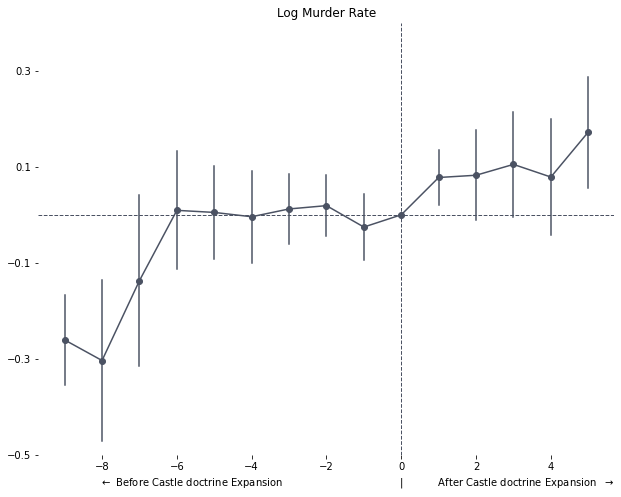

In [7]:
cl = "#4b5263"



std_plot = pd.melt(leadslags_plot, id_vars = ["mean", "label", "sd"], value_vars = ["lb", "ub"])

fig = plt.figure(figsize = (8, 6))
ax = fig.add_axes([.1, 1, 1, 1])
ax.spines[["right", "top", "bottom", "left"]].set_visible(False)


plt.scatter("label", "mean", data = leadslags_plot, color = cl)

for i in np.unique(std_plot["label"]):
    plt.plot("label", "value", data = std_plot[std_plot["label"] == i], color = cl)

# plt.fill_between("label", "lb", "ub", data = leadslags_plot, color = cl, alpha = .4)
plt.plot("label", "mean", data = leadslags_plot, color = cl)
plt.axvline(0, color = cl, lw = 1, linestyle = "--")

plt.axhline(0, color = cl, lw = 1, linestyle = "--")
plt.ylim(-.5, .4)
plt.title("Log Murder Rate")
ax.set_xlabel(r"$\leftarrow$ Before Castle doctrine Expansion                                     |           After Castle doctrine Expansion  $\rightarrow$", loc = "right" )
ax.set_yticks(np.arange(-.5, .41, .2));

